In [1]:
import fastbook
fastbook.setup_book()

In [3]:
from fastai2.vision.all import *
from fastbook import *
matplotlib.rc('image', cmap='Greys')

In [4]:
top_edge = tensor([-1,-1,-1],
                 [0,0,0],
                 [1,1,1]).float()

In [5]:
path = untar_data(URLs.MNIST_SAMPLE)

In [13]:
Path.BASE_PATH = path
path.ls()

[Path('labels.csv'), Path('train'), Path('valid')]

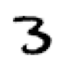

In [15]:
im3=Image.open(path/'train'/'3'/'12.png')
show_image(im3);

In [24]:
im3_t=tensor(im3)
(im3_t[0:3,0:3] * top_edge)

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [26]:
(im3_t[0:3,0:3]*top_edge).sum()

tensor(0.)

In [56]:
df=pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{'font-size':'8pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [35]:
(im3_t[4:7,6:9]*top_edge).sum()

tensor(762.)

In [36]:
(im3_t[7:10,17:20] * top_edge).sum()

tensor(-29.)

In [41]:
def apply_kernel(row, col, kernel):
    return (im3_t[row-1:row+2, col-1:col+2] * kernel).sum()

In [42]:
apply_kernel(5,7,top_edge)

tensor(762.)

In [55]:
[[(i,j) for j in range(1,5)] for i in range(1,5)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

In [58]:
df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


There are 20 rows and 10 columns in our image tensor(im3_t). 3X3 kernel is moved across 18 times in rows and 8 times in column making total 18+8=26 times. We choose range(1,27) to convolve over this image

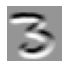

In [59]:
rng = range(1,27) 
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])
show_image(top_edge3);

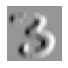

In [63]:
left_edge = tensor([-1,0,1],
                  [-1,0,1],
                  [-1,0,1]).float()
left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])
show_image(left_edge3);

In [89]:
diag1_edge = tensor([-1,0,1],
                   [0,1,-1],
                   [1,-1,0]).float()
diag2_edge = tensor([1,-1,0],
                   [0,1,-1],
                   [-1,0,1]).float()

edge_kernels = torch.stack([top_edge, left_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

In [90]:
edge_kernels.unsqueeze(1).shape
edge_kernels = edge_kernels.unsqueeze(1)

In [84]:
mnist = DataBlock((ImageBlock(cls=PILImageBW),CategoryBlock),
                  get_items = get_image_files,
                  get_y=parent_label,
                  splitter = GrandparentSplitter())

dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

In [85]:
xb,yb = to_cpu(xb),to_cpu(yb)

In [91]:
batch_features = F.conv2d(xb, edge_kernels) 

Previously we convolved over im3_t and stored the features in top_edge3 variable. Now we use Pytorch to convolve over batch of 64 images and store in batch_features.

In [92]:
batch_features.shape

torch.Size([64, 4, 26, 26])

Note that the height and width changed to 26X26. Later we add a padding=1 on both dimensions to get back to 28X28

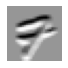

In [97]:
show_image(batch_features[0,0]);   #first batch_feature element height and width

In [98]:
simple_net = nn.Sequential(
            nn.Linear(28*28,30),
            nn.ReLU(),
            nn.Linear(30,1)
)

In [99]:
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [103]:
broken_cnn = sequential(
    nn.Conv2d(1, 30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,1,kernel_size=3, padding=1)
)

In [104]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

In [105]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [107]:
simple_cnn = sequential(
    conv(1,4),
    conv(4,8),
    conv(8,16),
    conv(16,32),
    conv(32,2,act=False),
    Flatten(),
)

In [108]:
simple_cnn(xb).shape

torch.Size([64, 2])

In [109]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)

In [110]:
learn.summary()

epoch,train_loss,valid_loss,accuracy,time


Sequential (Input shape: ['64 x 1 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 4 x 14 x 14     40         True      
________________________________________________________________
ReLU                 64 x 4 x 14 x 14     0          False     
________________________________________________________________
Conv2d               64 x 8 x 7 x 7       296        True      
________________________________________________________________
ReLU                 64 x 8 x 7 x 7       0          False     
________________________________________________________________
Conv2d               64 x 16 x 4 x 4      1,168      True      
________________________________________________________________
ReLU                 64 x 16 x 4 x 4      0          False     
________________________________________________________________
Conv2d               64 x 32 x 2 x 2      4,640      True      
___________________________________________________

In [112]:
learn.fit_one_cycle(2,0.01)

In [117]:
m = learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [121]:
m[0].weight.shape

torch.Size([4, 1, 3, 3])

First model layer has 40 parameters (or features) out of which 4*1*3*3 = 36 is weight and 4 is bias 

In [122]:
m[0].bias.shape   

torch.Size([4])

In [135]:
im = image2tensor(Image.open(path.cwd()/'image_bear.png'))
im.shape

torch.Size([4, 286, 244])

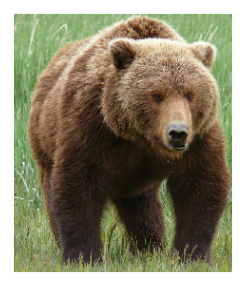

In [137]:
show_image(im);

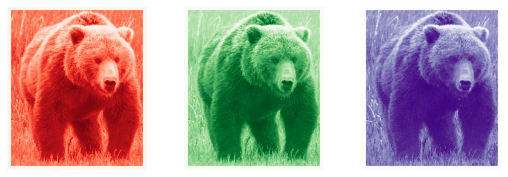

In [144]:
_,axs = subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Purples')):
    show_image(255-bear, ax=ax, cmap=color)


In [145]:
path = untar_data(URLs.MNIST)

In [146]:
Path.BASE_PATH = path

In [147]:
path.ls()

[Path('training'), Path('testing')]

In [150]:
def get_dls(bs=64):
    return DataBlock(
        blocks= (ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter('training','testing'),
    batch_tfms = Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

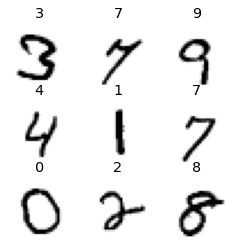

In [151]:
dls.show_batch(max_n=9, figsize=(4,4))

In [153]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [161]:
def simple_cnn():
    return sequential(
    conv(1,8,ks=5),
    conv(8,16),
    conv(16,32),
    conv(32,64),
    conv(64,10, act=False),
    Flatten()
    )

In [157]:
from fastai2.callback.hook import *

In [162]:
def fit(epochs=1):
    learn = Learner(dls, simple_cnn(),loss_func=F.cross_entropy, metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.06)
    return learn 

In [163]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.306288,2.306660,0.113500,00:24


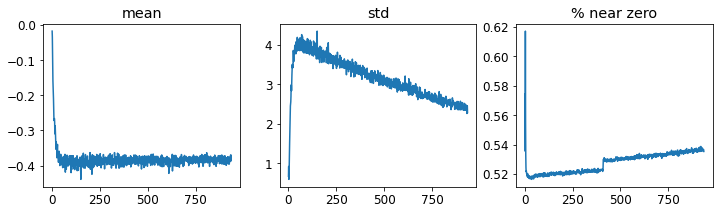

In [168]:
learn.activation_stats.plot_layer_stats(0)    #0 for first layer

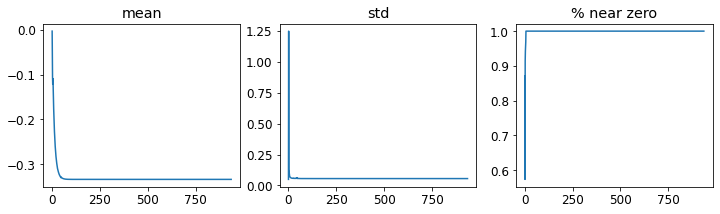

In [169]:
learn.activation_stats.plot_layer_stats(-2)

In [170]:
dls=get_dls(512)

In [172]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.319610,2.304445,0.095800,00:18


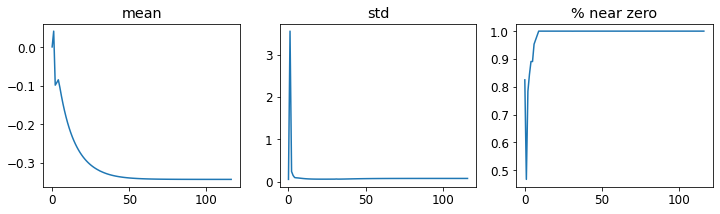

In [173]:
learn.activation_stats.plot_layer_stats(-2)

1cycle Training

In [174]:
def fit(epoch=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy, metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epoch, lr)
    return learn

In [175]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.211489,0.073489,0.975800,00:18


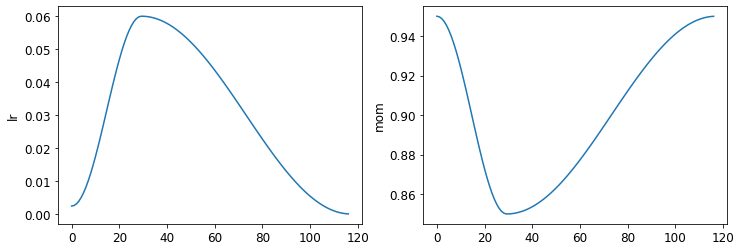

In [176]:
learn.recorder.plot_sched()

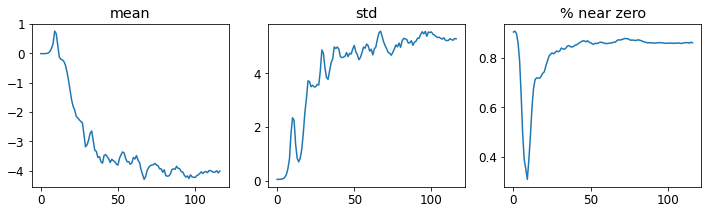

In [177]:
learn.activation_stats.plot_layer_stats(-2)

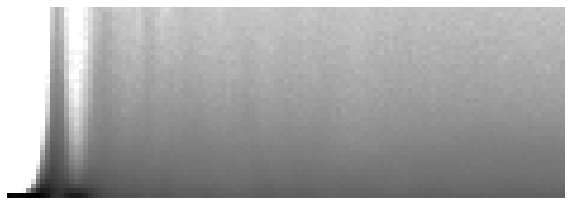

In [178]:
learn.activation_stats.color_dim(-2)

Batch Normalization

In [180]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    layers.append(nn.BatchNorm2d(nf))
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [181]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.134557,0.057532,0.984900,00:20


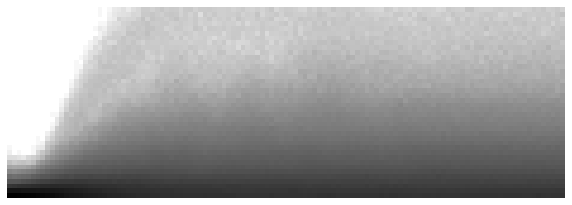

In [182]:
learn.activation_stats.color_dim(-4)

In [183]:
learn = fit(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.188359,0.161168,0.950900,00:20
1,0.079835,0.073863,0.977800,00:20
2,0.052516,0.048264,0.983700,00:20
3,0.030424,0.029391,0.990200,00:20
4,0.016136,0.023800,0.992600,00:20


In [184]:
learn = fit(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.188624,0.138114,0.958400,00:20
1,0.078426,0.096447,0.970400,00:20
2,0.050606,0.046777,0.985200,00:20
3,0.032564,0.028130,0.990600,00:20
4,0.016372,0.023352,0.992700,00:20
